In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импортируем необходимые модули
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

# Импортируем библиотеки для создания модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [2]:
# Загрузка данных
data = pd.read_csv('sp500_historical_data.csv')

# Фильтруем данные для одной акции
ticker = 'AAPL'  # Замените на нужный тикер
df = data[data['Ticker'] == ticker]

# Сортируем данные по дате
df = df.sort_values('Date')

# Преобразуем столбец 'Date' в формат datetime и устанавливаем его в качестве индекса
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Выбираем столбец 'Close' для прогнозирования
prices = df[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

In [3]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:]

# Создание обучающих и тестовых наборов данных
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step -1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [4]:
# Изменение формы данных для LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

# Создание модели LSTM
model = Sequential()
model.add(Input(shape=(60,1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam')

In [5]:
# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2101
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0277
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0144
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0051
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0028
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023


In [6]:
# Прогнозирование
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [7]:
# Обратное масштабирование предсказаний
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

In [8]:
# Расчет RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_actual[0], train_predict[:,0]))
test_rmse = math.sqrt(mean_squared_error(y_test_actual[0], test_predict[:,0]))

print(f'RMSE на обучающей выборке: {train_rmse}')
print(f'RMSE на тестовой выборке: {test_rmse}')

RMSE на обучающей выборке: 6.078638807930317
RMSE на тестовой выборке: 7.321982167951962


In [9]:
# Сдвиг предсказаний для графика
look_back = 60
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

In [10]:
# Обратное масштабирование всего набора данных для графика
prices_actual = scaler.inverse_transform(scaled_data)

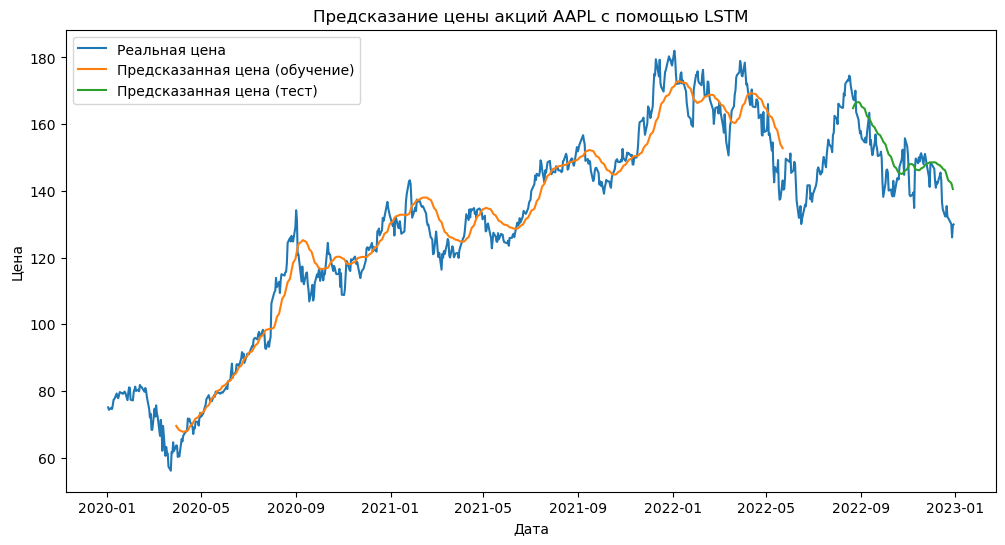

In [11]:
# Построение графика
plt.figure(figsize=(12,6))
plt.plot(df.index, prices_actual, label='Реальная цена')
plt.plot(df.index, trainPredictPlot, label='Предсказанная цена (обучение)')
plt.plot(df.index, testPredictPlot, label='Предсказанная цена (тест)')
plt.title(f'Предсказание цены акций {ticker} с помощью LSTM')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [12]:
# Анализ расхождений
differences = y_test_actual[0] - test_predict[:,0]

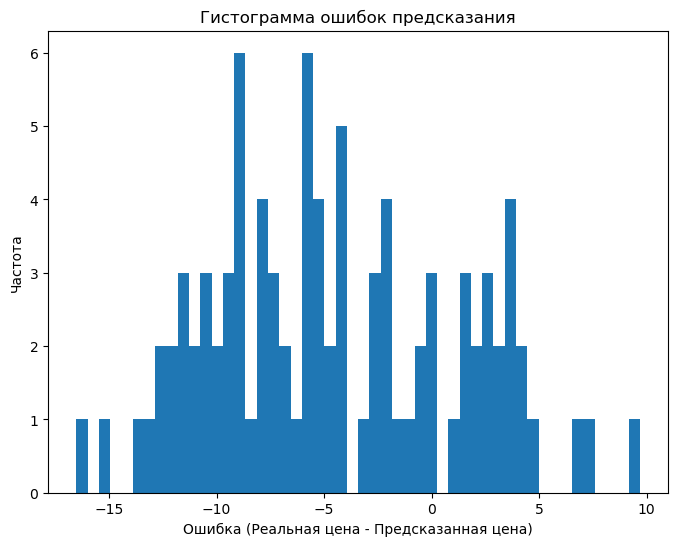

In [13]:
# Построение гистограммы ошибок
plt.figure(figsize=(8,6))
plt.hist(differences, bins=50)
plt.title('Гистограмма ошибок предсказания')
plt.xlabel('Ошибка (Реальная цена - Предсказанная цена)')
plt.ylabel('Частота')
plt.show()

In [14]:
# Вывод статистики ошибок
mean_error = np.mean(differences)
std_error = np.std(differences)
print(f'Средняя ошибка предсказания: {mean_error}')
print(f'Стандартное отклонение ошибки предсказания: {std_error}')

Средняя ошибка предсказания: -4.523575248299064
Стандартное отклонение ошибки предсказания: 5.757489890636593
